In [292]:
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import pandas as pd, numpy as np, math
import matplotlib.pyplot as plt
import matplotlib.ticker, 
from datetime import datetime


In [778]:
scopes = ['https://www.googleapis.com/auth/spreadsheets.readonly']

spreadsheet_id = '1IKBqledzC7gp_YByndemu9L0-EnWQpG5ZiXVkQZaPz8'
spreadsheet_name = 'da_assignment!A1:Z'

creds = None

if os.path.exists('token.pickle'):
    with open('token.pickle', 'rb') as token:
        creds = pickle.load(token)
        
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file('/home/trang/Downloads/credentials.json', scopes)
        creds = flow.run_local_server(port=0)

    with open('token.pickle', 'wb') as token:
        pickle.dump(creds, token)

service = build('sheets','v4', credentials = creds)

request_data = service.spreadsheets().values().get(spreadsheetId=spreadsheet_id, range=spreadsheet_name)
data = request_data.execute()

In [780]:
publications = pd.DataFrame(data['values'][1:], columns=data['values'][0])

In [44]:
## Clean data
## Remove NA values
publications['is_na'] = publications.isna().apply(sum,1)
publications[publications['is_na'] > 0]

Empty DataFrame
Columns: [publication_time, publication_id, duplicate_id, publication_channel, publication_language, predicted_relevance_probability, topic, is_relevant, verification_date, is_na]
Index: []

In [784]:
## Empty value
publications['is_empty'] = publications.apply(lambda x:x == '', 1).apply(sum,1)
empty_detail = publications.apply(lambda x:x == '', 0).apply(sum,0)
empty_detail

publication_time                     0
publication_id                       1
duplicate_id                         2
publication_channel                  0
publication_language                 0
predicted_relevance_probability      2
topic                               81
is_relevant                        335
verification_date                    0
is_empty                             0
dtype: int64

In [782]:
## Clean empty value
publications_non_empty = publications[publications['is_empty'] == 0]

In [775]:
## Remove duplicate duplicate_id values
publications_cleaned = publications_non_empty.sort_values(['duplicate_id', 'verification_date', 'publication_time'], ascending = [True,False,True]).drop_duplicates(keep='first')
publications_cleaned['predicted_relevance_probability'] = publications_cleaned['predicted_relevance_probability'].astype('float64')
publications_cleaned['publication_time'] = publications_cleaned['publication_time'].astype('datetime64[ns]')
publications_cleaned['verification_date'] = publications_cleaned['verification_date'].astype('datetime64[ns]')
publications_cleaned['is_relevant'] = publications_cleaned['is_relevant'] == 'TRUE'

In [783]:
# Data aggregation
# aggregate by topic, return count of publication
agg_topic = publications_cleaned.groupby('topic').count()['publication_id'].sort_values()
agg_topic.shape

In [662]:
# Aggregate by publication_language and publication_channel, return the count of publications
agg_language_channel = publications_cleaned.groupby(['publication_language','publication_channel']).count()['publication_id']

In [663]:
# Aggregate by publication_language and topic and is_relevant, return the count of publications
agg_language_topic_relevant = publications_cleaned.groupby(['publication_language','topic','is_relevant']).count()['publication_id']

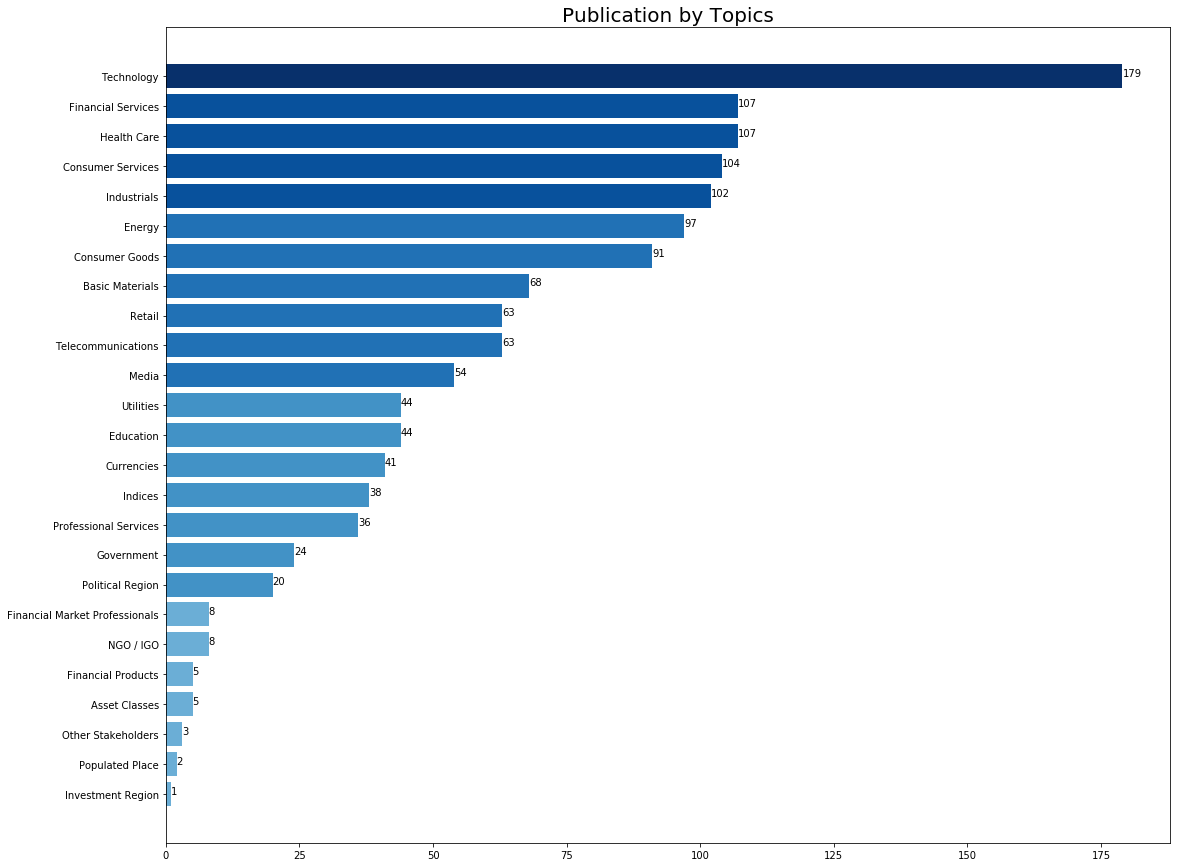

In [771]:
# Data Vizualization
# Visualize aggregations 2a, 2b
all_topic_summary = agg_topic.values
all_topic_name = agg_topic.index
colors = ['#6baed6','#6baed6','#6baed6','#6baed6','#6baed6','#6baed6','#6baed6','#4292c6','#4292c6','#4292c6','#4292c6','#4292c6','#4292c6', '#4292c6',
          '#2171b5','#2171b5','#2171b5','#2171b5','#2171b5','#2171b5','#08519c', '#08519c', '#08519c', '#08519c', '#08306b']

fig = plt.figure(figsize = (18,15))
ax = fig.add_subplot(111)
    
plt.barh(y = all_topic_name, width = all_topic_summary, orientation = 'horizontal', color=colors)
plt.title('Publication by Topics', fontsize=20)

for index,val in enumerate(all_topic_summary):
    ax.text(val,index,str(val), fontsize=10)

Text(0.5, 1.0, 'Publication by Topics and Language')

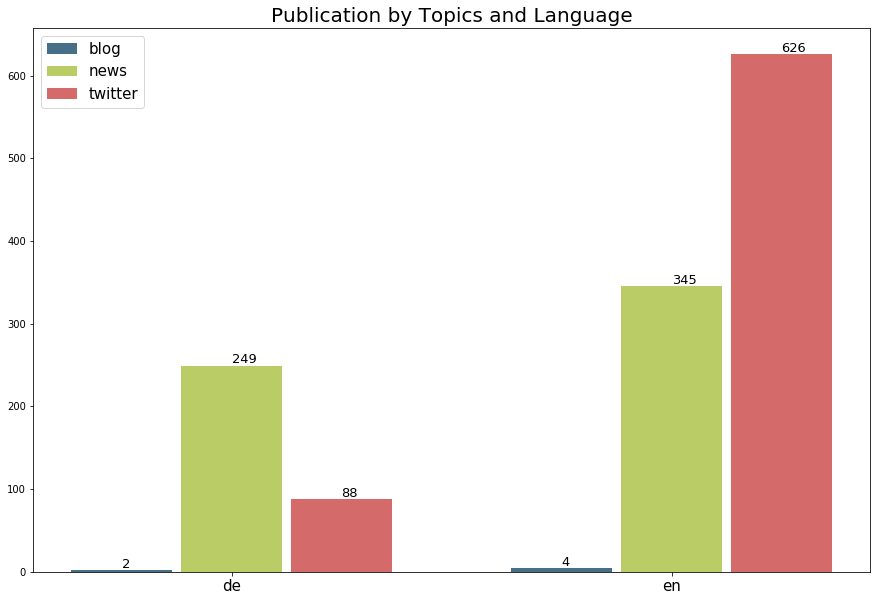

In [774]:
agg_language_channel
agg_language_channel_reset = agg_language_channel.reset_index()

width = 0.55

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(111)
languages = agg_language_channel_reset['publication_language'].drop_duplicates().values
channels = agg_language_channel_reset['publication_channel'].drop_duplicates().values
colors = ['#486F88', '#B9CC66', '#D46A6A']
xticks = []
xticklabels = []
        
## Create chart and legend
for channel_idx, channel in enumerate(channels):
    counts = []
    indexes = []
    lang_indexes = []
    for idx,language in enumerate(languages):
        is_valid_condition = ((agg_language_channel_reset['publication_language'] == language) & (agg_language_channel_reset['publication_channel'] == channel))
        counts.append(int(agg_language_channel_reset[is_valid_condition]['publication_id']))
        indexes.append(agg_language_channel_reset[is_valid_condition].index[0])
        lang_indexes.append(idx)
    
    x_chart = (np.array(indexes) + np.array(lang_indexes))*0.6
    plt.bar(x_chart, counts, width=width, color=colors[channel_idx], label=channel)

    for x,y, dis in zip(indexes, counts, lang_indexes):
        ax.text((x + dis) * 0.6, y+ 3, str(y), fontsize=13)

## Add groups name
for idx, language in enumerate(languages):
    is_valid_condition = ((agg_language_channel_reset['publication_language'] == language))
    indexes = agg_language_channel_reset[is_valid_condition].index
    mid = math.floor(len(indexes) / 2)
    xticks.append((indexes[mid] + idx ) * 0.6)
    xticklabels.append(language)     
    
ax.legend(fontsize=15)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, fontsize=15)
plt.title('Publication by Topics and Language', fontsize=20)

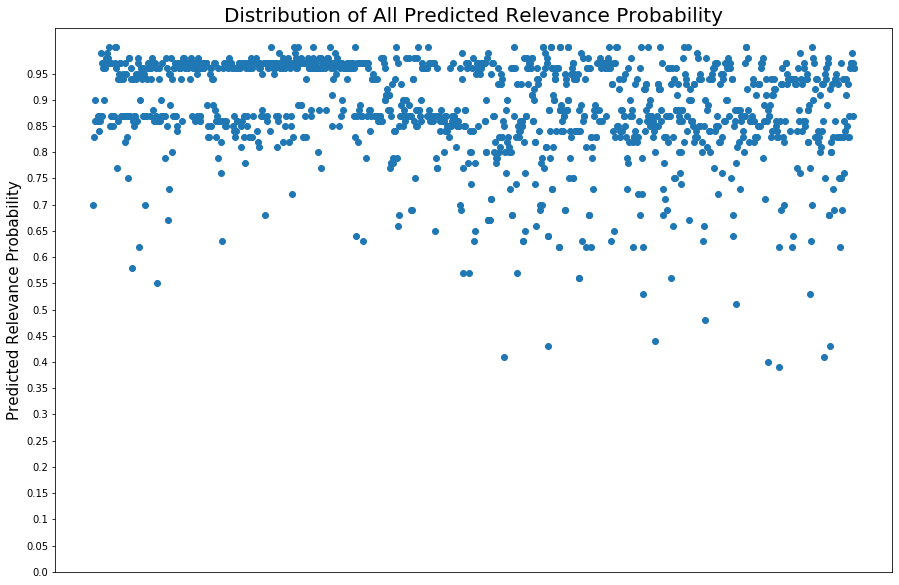

In [761]:
# Visualize the distribution of all predicted_relevance_probability values

plt.figure(figsize=(15,10))

predicted_relevance_probability = np.round(np.array(publications_cleaned['predicted_relevance_probability'], dtype=float),2)

plt.scatter(x = publications_cleaned['publication_id'], y = predicted_relevance_probability)
plt.yticks(np.arange(0, 1, step=0.05),np.round(np.arange(0, 1, step=0.05),2))
plt.xticks([],[])
plt.title('Distribution of All Predicted Relevance Probability', fontsize=20)
plt.ylabel('Predicted Relevance Probability', fontsize=15)
plt.show()

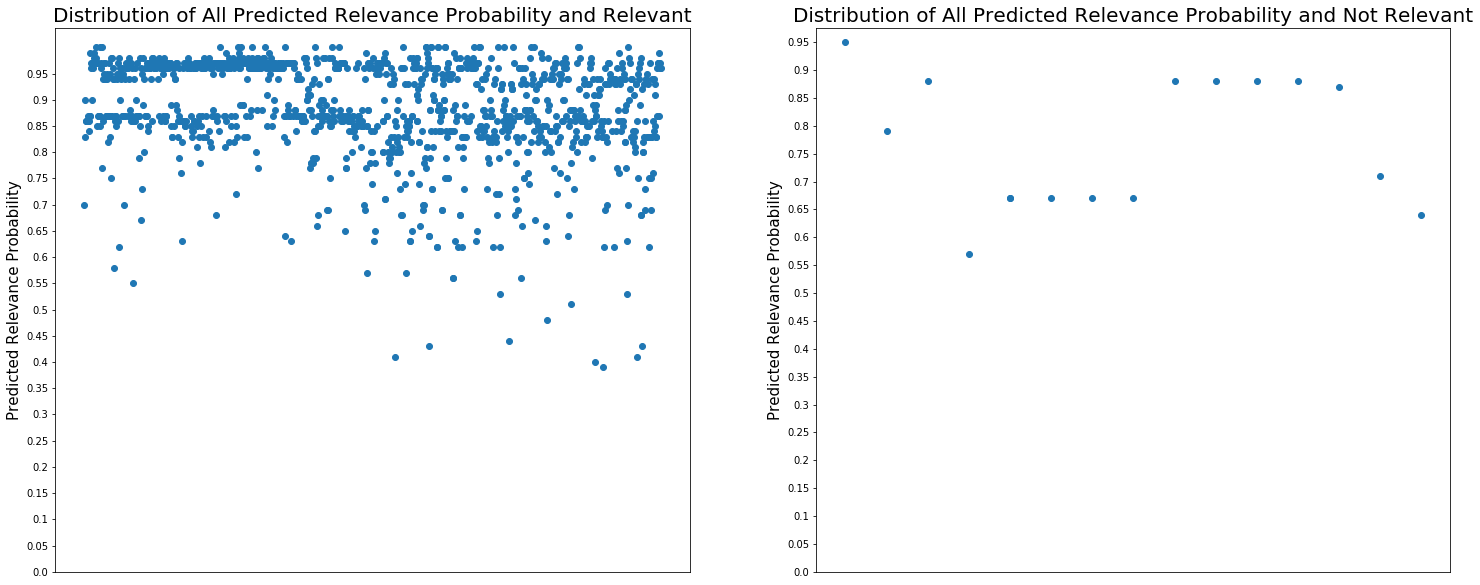

In [760]:
# Compare the distribution of predicted_relevance_probability when is_relevant = True against when is_relevant = False
fig = plt.figure(figsize=(25,10))

plt.subplot(121)
is_relevant = publications_cleaned['is_relevant']

predicted_relevance_probability = np.round(np.array(publications_cleaned[is_relevant]['predicted_relevance_probability'], dtype=float),2)

plt.scatter(x = publications_cleaned[is_relevant]['publication_id'], y = predicted_relevance_probability)
plt.yticks(np.arange(0, 1, step=0.05),np.round(np.arange(0, 1, step=0.05),2))
plt.xticks([],[])
plt.title('Distribution of All Predicted Relevance Probability and Relevant', fontsize=20)
plt.ylabel('Predicted Relevance Probability', fontsize=15)

plt.subplot(122)
not_relevant = ~ publications_cleaned['is_relevant']

predicted_relevance_probability = np.round(np.array(publications_cleaned[not_relevant]['predicted_relevance_probability'], dtype=float),2)

plt.scatter(x = publications_cleaned[not_relevant]['publication_id'], y = predicted_relevance_probability)
plt.yticks(np.arange(0, 1, step=0.05),np.round(np.arange(0, 1, step=0.05),2))
plt.xticks([],[])
plt.title('Distribution of All Predicted Relevance Probability and Not Relevant', fontsize=20)
plt.ylabel('Predicted Relevance Probability', fontsize=15)
plt.show()

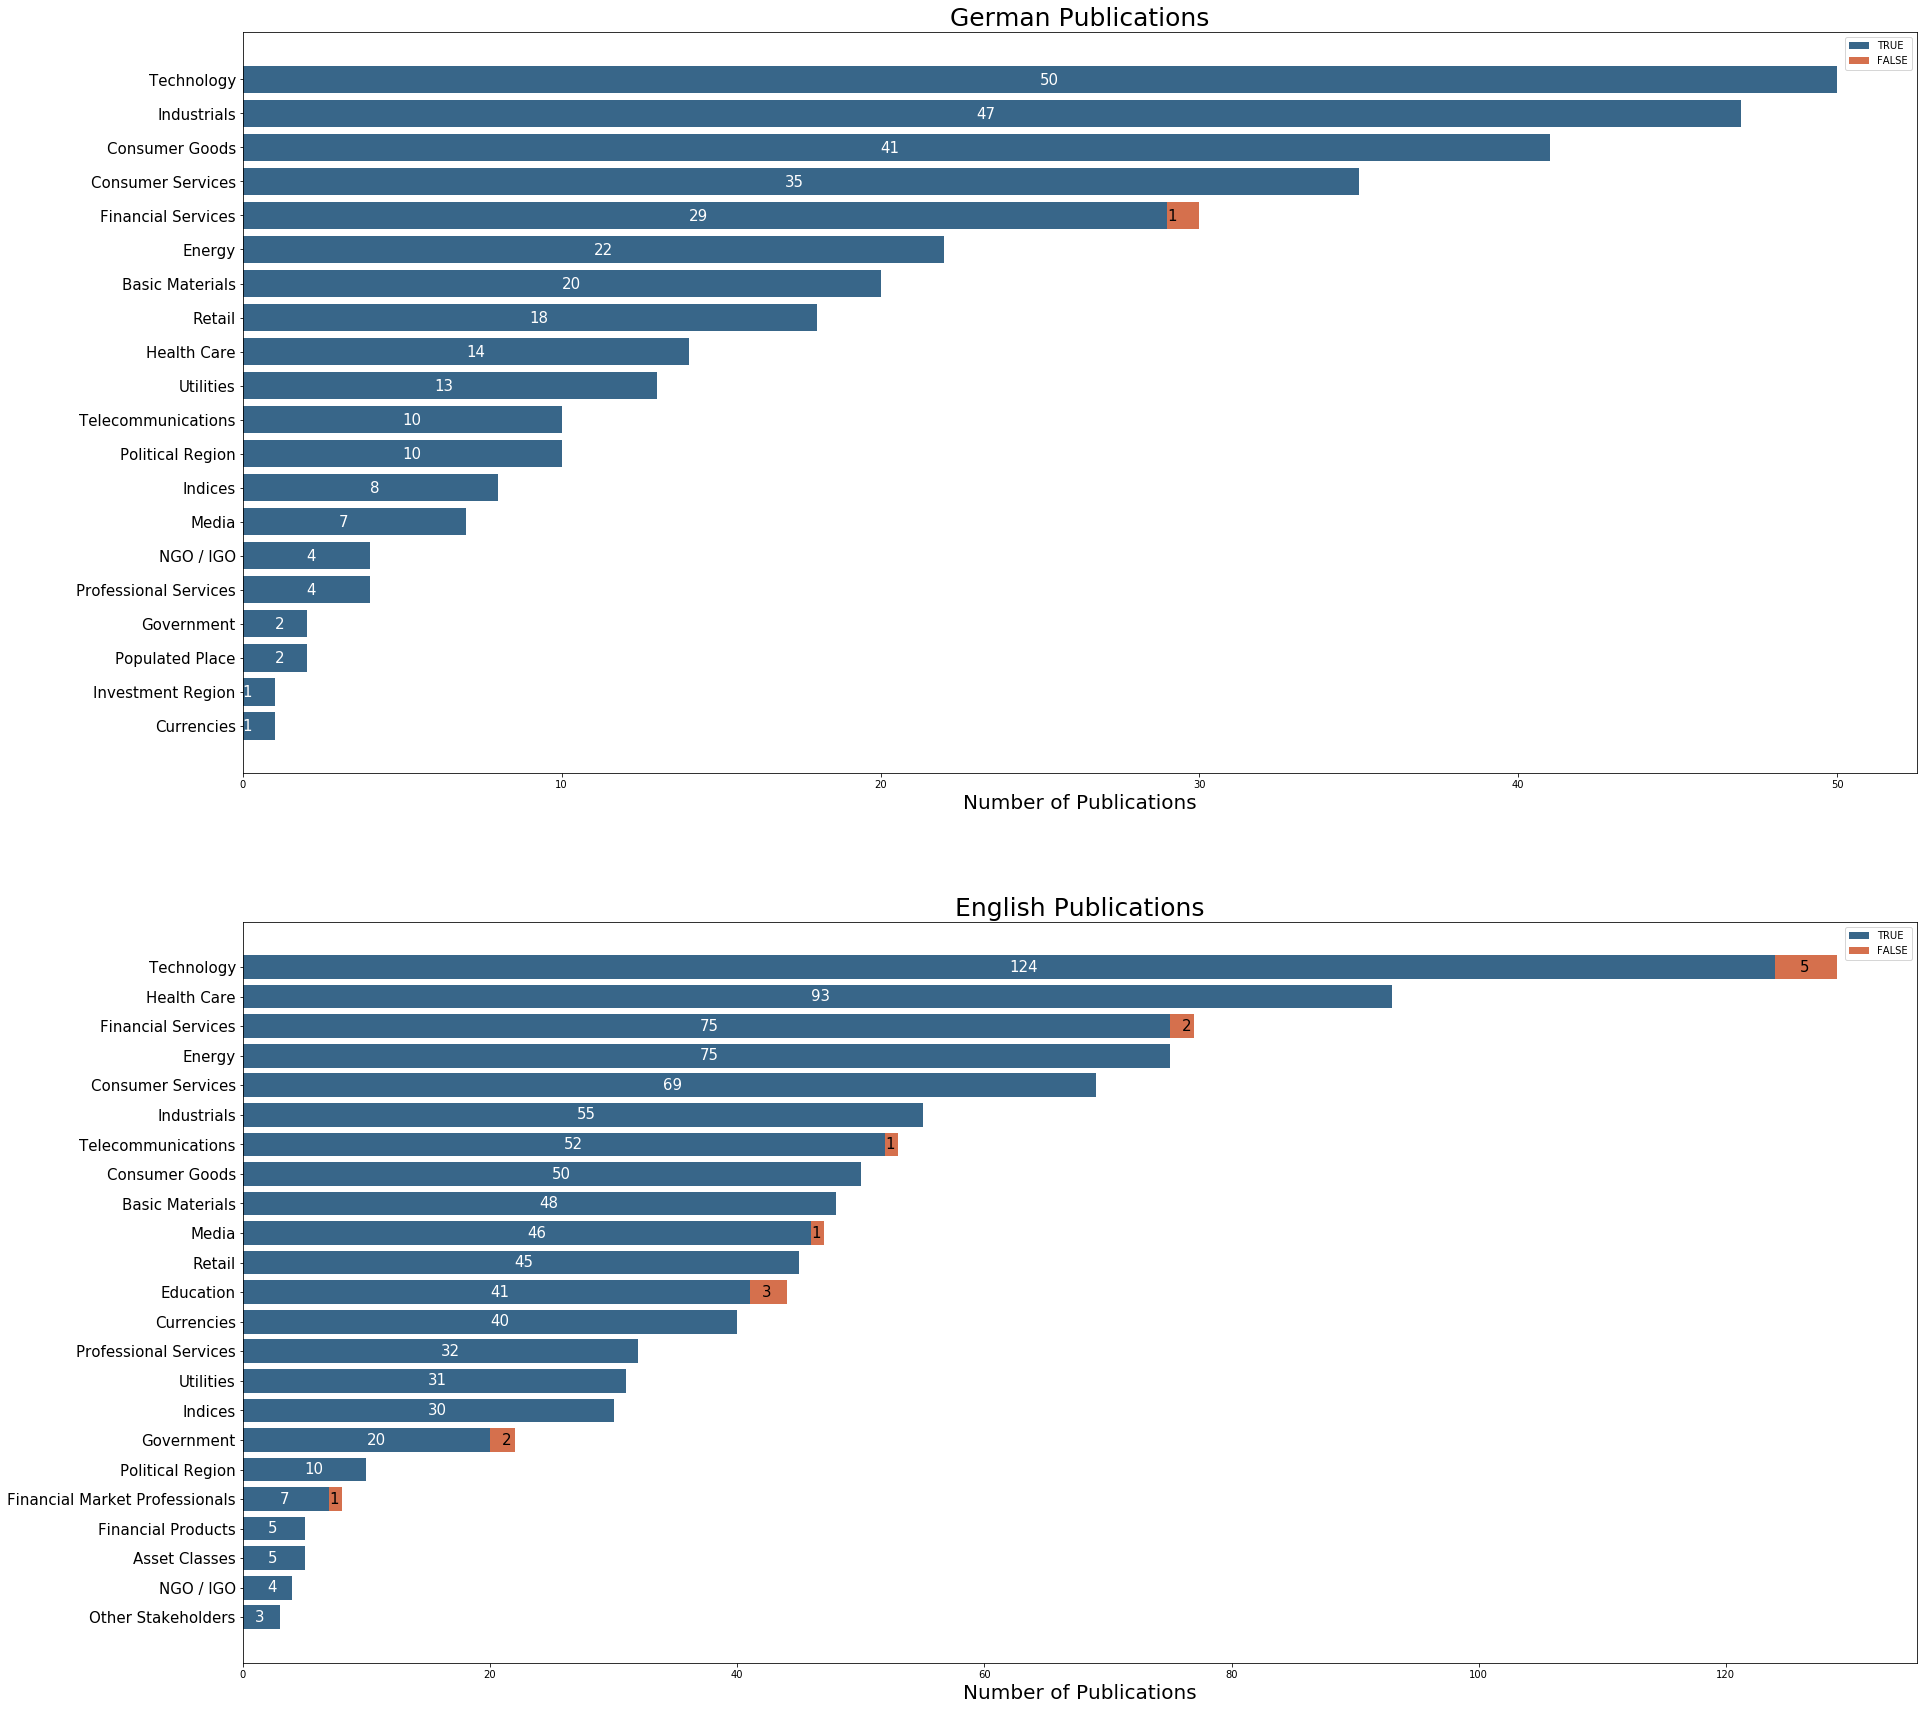

In [751]:
# Visualize aggregation 2c above
language_dict = {'en':'English', 'de':'German'}
agg_language_topic_relevant_reset = agg_language_topic_relevant.reset_index()
agg_language_topic_relevant_reset = agg_language_topic_relevant_reset.rename(columns={'publication_id':'counts'})
agg_language_topic_relevant_reset

all_languages = agg_language_topic_relevant_reset['publication_language'].drop_duplicates().values

ncols_subplots = 1
nrows_subplots = math.floor(len(all_languages) / ncols_subplots)

fig = plt.figure(figsize=(30,30))

for idx_lan, language in enumerate(all_languages):    
    ax = plt.subplot(nrows_subplots, ncols_subplots, idx_lan+1)
    data_by_language = agg_language_topic_relevant_reset[agg_language_topic_relevant_reset['publication_language'] == language].sort_values(by='counts')
    data_by_language = data_by_language.reset_index(drop=True)   
    
    ## relevant values
    data_relevant = data_by_language[data_by_language['is_relevant']].reset_index(drop=True)
    topics = data_relevant['topic']
    counts = data_relevant['counts']
    plt.barh(topics,counts, label='TRUE', color='#386689')
    
    for idx, number in enumerate(counts):
        x_loc = math.floor(number / 2)
        ax.text(x_loc, idx - 0.15, str(number), fontsize=15, color='white')
    
    ## not relevant values
    data_not_relevant = data_by_language[~ data_by_language['is_relevant']]
    data_merge = pd.merge(data_not_relevant, data_relevant, how='inner', on='topic', suffixes=['_not_relevant', '_relevant'])
    n_topics = data_merge['topic']
    n_counts = data_merge['counts_not_relevant']
    n_left = data_merge['counts_relevant']
    n_bottom_indexes = topics[topics.isin(n_topics)].index
    plt.barh(n_topics, n_counts, label='FALSE', left=n_left, color='#D5704D')  

    for idx, (number, bottom, topic) in enumerate(zip(n_counts, n_left, n_topics)):
        x_loc = math.floor(number / 2) + bottom
        y_loc = (topics[topics.isin([topic])].index.values)[0]
        ax.text(x_loc, y_loc - 0.15, str(number), fontsize=15)
        
    plt.legend()
    plt.xlabel('Number of Publications', fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(language_dict[language] + ' Publications', fontsize=25)
    
plt.show()

In [710]:
# Measuring prediction performance:
    # With is_relevant as ground truths and predicted_relevance_probability as predictions, compute performance metrics for this sample at Threshold  = 0.50
# Performance metrics: (for this assignment) include F1-score, Precision, Recall, Accuracy
    
threshold = 0.5
data_prediction = publications_cleaned.copy()
data_prediction['prediction']  = (data_prediction['predicted_relevance_probability'] >= threshold)
true_positive = sum(data_prediction['is_relevant'] & data_prediction['prediction'])
true_nagative = sum(( ~ data_prediction['is_relevant']) & ( ~ data_prediction['prediction']))
false_positive = sum(( ~ data_prediction['is_relevant']) &  data_prediction['prediction'])
false_nagative = sum((  data_prediction['is_relevant']) & ( ~ data_prediction['prediction']))

precision = round(true_positive / (true_positive + false_positive),4)
recall = round(true_positive / (true_positive + false_nagative),4)
accuracy = round((true_positive + true_nagative) / (true_positive + true_nagative + false_positive + false_nagative),4)
f1_score = round(2 *((recall * precision) / (recall + precision)),4)

print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print('f1_score: ', f1_score)


precision:  0.9877
recall:  0.9938
accuracy:  0.9817
f1_score:  0.9907


In [713]:
# With is_relevant as ground truths and predicted_relevance_probability as predictions, 
# compute performance metrics for this sample for publication_language = “de” 
# at these Threshold values [0.40, 0.50, 0.60, 0.70, 0.80, 0.90]. 
# Among those threshold values, which will give the highest F1-score for publication_language = “de”?
language_filter = 'de'
all_thresholds = [0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
all_f1_scores = {}

data_de = publications_cleaned[publications_cleaned['publication_language'] == language_filter].copy()
for threshold in all_thresholds:
    data_de['prediction']  = (data_de['predicted_relevance_probability'] >= threshold)
    true_positive = sum(data_de['is_relevant'] & data_de['prediction'])
    true_nagative = sum(( ~ data_de['is_relevant']) & ( ~ data_de['prediction']))
    false_positive = sum(( ~ data_de['is_relevant']) &  data_de['prediction'])
    false_nagative = sum(( data_de['is_relevant']) & ( ~ data_de['prediction']))

    precision = round(true_positive / (true_positive + false_positive),4)
    recall = round(true_positive / (true_positive + false_nagative),4)
    accuracy = round((true_positive + true_nagative) / (true_positive + true_nagative + false_positive + false_nagative),4)
    all_f1_scores[threshold] = round(2 *((recall * precision) / (recall + precision)),4)

max_f1_score = 0
for val in all_f1_scores.values():
    if val > max_f1_score:
        max_f1_score = val

for key in all_f1_scores.keys():
    if all_f1_scores[key] == max_f1_score:
        print('threshold {0} has max f1_score is:  {1}'.format(key, max_f1_score))


threshold 0.4 has max f1_score is:  0.9985


In [714]:
# Determine the Threshold (precise to 4 decimal points e.g. 0.1234) such that the F1-score for this sample for publication_language = “en” is highest

language_filter = 'en'
all_thresholds = [0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
all_f1_scores = {}

data_de = publications_cleaned[publications_cleaned['publication_language'] == language_filter].copy()
for threshold in all_thresholds:
    data_de['prediction']  = (data_de['predicted_relevance_probability'] >= threshold)
    true_positive = sum(data_de['is_relevant'] & data_de['prediction'])
    true_nagative = sum(( ~ data_de['is_relevant']) & ( ~ data_de['prediction']))
    false_positive = sum(( ~ data_de['is_relevant']) &  data_de['prediction'])
    false_nagative = sum(( data_de['is_relevant']) & ( ~ data_de['prediction']))

    precision = round(true_positive / (true_positive + false_positive),4)
    recall = round(true_positive / (true_positive + false_nagative),4)
    accuracy = round((true_positive + true_nagative) / (true_positive + true_nagative + false_positive + false_nagative),4)
    all_f1_scores[threshold] = round(2 *((recall * precision) / (recall + precision)),4)

max_f1_score = 0
for val in all_f1_scores.values():
    if val > max_f1_score:
        max_f1_score = val

for key in all_f1_scores.keys():
    if all_f1_scores[key] == max_f1_score:
        print('threshold {0} has max f1_score is:  {1}'.format(key, max_f1_score))


threshold 0.4 has max f1_score is:  0.9917
threshold 0.5 has max f1_score is:  0.9917
threshold 0.6 has max f1_score is:  0.9917


In [759]:
publications_cleaned.groupby('publication_id').count().sort_values('publication_time', ascending=False)

publication_time  duplicate_id  publication_channel  \
publication_id                                                                  
59094a1426d81500ab769625                 3             3                    3   
592b0864037bb00067e0577e                 3             3                    3   
592a96c5037bb00067e052b1                 2             2                    2   
5909b78b26d81500abb5e386                 2             2                    2   
5923fda2752f554140e6729d                 2             2                    2   
...                                    ...           ...                  ...   
5925d734af14ca00a5046377                 1             1                    1   
5925e192fa50776c848262fb                 1             1                    1   
5925e916af14ca00a516cd86                 1             1                    1   
5925e963fa50776c84827dd5                 1             1                    1   
59789c17ccef280090dee592                 1             1                    1   

                          publication_language  \
publication_id                                   
59094a1426d81500ab769625                     3   
592b0864037bb00067e0577e                     3   
592a96c5037bb00067e052b1                     2   
5909b78b26d81500abb5e386                     2   
5923fda2752f554140e6729d                     2   
...                                        ...   
5925d734af14ca00a5046377                     1   
5925e192fa50776c848262fb                     1   
5925e916af14ca00a516cd86                     1   
5925e963fa50776c84827dd5                     1   
59789c17ccef280090dee592                     1   

                          predicted_relevance_probability  topic  is_relevant  \
publication_id                                                                  
59094a1426d81500ab769625                                3      3            3   
592b0864037bb00067e0577e                                3      3            3   
592a96c5037bb00067e052b1                                2      2            2   
5909b78b26d81500abb5e386                                2      2            2   
5923fda2752f554140e6729d                                2      2            2   
...                                                   ...    ...          ...   
5925d734af14ca00a5046377                                1      1            1   
5925e192fa50776c848262fb                                1      1            1   
5925e916af14ca00a516cd86                                1      1            1   
5925e963fa50776c84827dd5                                1      1            1   
59789c17ccef280090dee592                                1      1            1   

                          verification_date  is_na  is_empty  
publication_id                                                
59094a1426d81500ab769625                  3      3         3  
592b0864037bb00067e0577e                  3      3         3  
592a96c5037bb00067e052b1                  2      2         2  
5909b78b26d81500abb5e386                  2      2         2  
5923fda2752f554140e6729d                  2      2         2  
...                                     ...    ...       ...  
5925d734af14ca00a5046377                  1      1         1  
5925e192fa50776c848262fb                  1      1         1  
5925e916af14ca00a516cd86                  1      1         1  
5925e963fa50776c84827dd5                  1      1         1  
59789c17ccef280090dee592                  1      1         1  

[1227 rows x 10 columns]

In [754]:
false_dataset = publications_cleaned[~publications_cleaned['is_relevant']].copy()
publications_cleaned[publications_cleaned['duplicate_id'].isin(false_dataset['duplicate_id'])]

publication_time            publication_id              duplicate_id  \
225  2017-06-05 13:11:37  593559361a208e0a8d14b4b7  57b4a94f421d85006639a820   
227  2017-06-05 13:33:18  5935719c2b006300681684d4  57b4a94f421d85006639a820   
223  2017-06-05 20:26:12  5935bf5b1a208e0ac92783f7  57b4a94f421d85006639a820   
229  2017-06-05 21:03:20  5935c8141a208e0ac93038e9  57b4a94f421d85006639a820   
230  2017-06-05 21:47:37  5935d22a1a208e0ad3cfe300  57b4a94f421d85006639a820   
...                  ...                       ...                       ...   
1028 2017-05-19 10:58:55  591ed010fa50776c846fa5e5  591b729a84921b01e6ad966c   
1027 2017-05-19 20:49:25  591f5abe69e1cb00cc645462  591b729a84921b01e6ad966c   
1204 2017-06-17 17:48:47  59456c5d3222c2398c57f53a  5943df193222c2356a85d1a2   
1290 2017-06-28 02:00:17  59530eb993fc5311e5473cf9  594d413d93fc530428567937   
1289 2017-06-25 18:32:17  595002b293fc530aeacd4a8c  594d413d93fc530428567937   

     publication_channel publication_language  \
225              twitter                   en   
227                 news                   en   
223              twitter                   en   
229              twitter                   en   
230              twitter                   en   
...                  ...                  ...   
1028                news                   en   
1027             twitter                   en   
1204             twitter                   de   
1290             twitter                   en   
1289             twitter                   en   

      predicted_relevance_probability                           topic  \
225                            0.9609                           Media   
227                            0.6744              Telecommunications   
223                            0.7263              Telecommunications   
229                            0.9520              Telecommunications   
230                            0.9490              Telecommunications   
...                               ...                             ...   
1028                           0.9990                      Government   
1027                           0.8685                      Government   
1204                           0.7079              Financial Services   
1290                           0.6232  Financial Market Professionals   
1289                           0.6354              Financial Services   

      is_relevant verification_date  is_na  is_empty  
225          True        2017-12-06      0         0  
227          True        2017-12-06      0         0  
223          True        2017-12-06      0         0  
229         False        2017-12-06      0         0  
230          True        2017-12-06      0         0  
...           ...               ...    ...       ...  
1028         True        2017-05-25      0         0  
1027        False        2017-05-25      0         0  
1204        False        2017-06-19      0         0  
1290         True        2017-06-29      0         0  
1289        False        2017-06-28      0         0  

[363 rows x 11 columns]

In [ ]:
# Based on the analysis you have done (within and/or beyond the scope of the above tasks), 
# what can you conclude about this classifier and which feature/variable should we investigate further to improve it?

* As we can see in German and English publications charts, German has False prediction less than English publications. So we focus to English publications
* All of predicted relevance_probabilities larger than 0.4 (the minimum threshold). So we can not reduce threshold to increasing F1_scores, accurrancy, precicion and recall.
* In the table above, we can see that there are true publications those have same duplicate_id with false publications

#### From those information, we should go further in English publications in twitter channel, focus on Technology, Financial Serivices, Education, Goverment, Media, Finacial Markets Proffesionals, Telecommunications topics. Specially, when a topic has false value, but there are true for another publishers those have the same content. 
#### In conclusion, we should go further on publishers those are gotten false relevant.